<div>
    <h1>Image Overlay with Rotation</h1>
    <h2><code>MohammadReza Hasanzadeh</code></h2>
    <br>
    <p>A Python script for Jupyter Notebook that overlays a foreground image onto a background using a mask and supports rotation. Built with OpenCV and NumPy.</p>
    <p><strong>Features:</strong></p>
    <ul>
        <li><strong>Overlay:</strong> Places foreground at user-defined coordinates (<code>x, y</code>) with a mask.</li>
        <li><strong>Rotation:</strong> Rotates foreground and mask without resizing or interpolation (<code>INTER_NEAREST</code>).</li>
        <li><strong>Masking:</strong> Auto-detects background color in RGB for masking.</li>
        <li><strong>User Input:</strong> Accepts image paths, coordinates, angle, and tolerance.</li>
        <li><strong>Display:</strong> Shows result using Matplotlib.</li>
    </ul>
    <p><strong>Prerequisites:</strong></p>
    <ul>
        <li>Install: <code>pip install opencv-python numpy matplotlib</code></li>
        <li>Images: Background (e.g., <code>background.jpg</code>) and foreground with uniform background color (e.g., <code>foreground.png</code>).</li>
    </ul>
    <p><strong>Usage:</strong></p>
    <p>Run in Jupyter, input image paths, tolerance, coordinates, and rotation angle. The script overlays the rotated foreground and displays the result.</p>
    <p><strong>Notes:</strong></p>
    <ul>
        <li>Ensure uniform background color in foreground image.</li>
        <li>Coordinates are clamped to fit background.</li>
    </ul>
</div>

In [48]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [49]:
class ImageOverlay:
    def __init__(self, background_path, foreground_path):
        self.background = cv.imread(background_path)
        if self.background is None:
            raise FileNotFoundError("Background picture does not exist")

        self.foreground = cv.imread(foreground_path, cv.IMREAD_UNCHANGED)
        if self.foreground is None:
            raise FileNotFoundError("Foreground picture does not exist")

        self.mask = None

    def detect_background_color(self, border_size=10):
        h, w = self.foreground.shape[:2]
        borders = [
            self.foreground[:border_size, :],
            self.foreground[-border_size:, :],
            self.foreground[:, :border_size],
            self.foreground[:, -border_size:]
        ]

        pixels = np.vstack([border.reshape(-1, 3) for border in borders])
        dominant_color = np.mean(pixels, axis=0).astype(np.uint8)
        return dominant_color.tolist()

    def create_mask(self, tolerance=30):
        if tolerance < 0:
            raise ValueError("Tolerance must be a non-negative number")

        rgb_color = self.detect_background_color()

        lower = np.array(rgb_color, dtype=np.int32) - tolerance
        upper = np.array(rgb_color, dtype=np.int32) + tolerance
        lower = np.clip(lower, 0, 255).astype(np.uint8)
        upper = np.clip(upper, 0, 255).astype(np.uint8)

        if self.foreground.shape[2] == 4:
            self.foreground = self.foreground[:, :, :3]
        elif self.foreground.shape[2] != 3:
            raise ValueError("Unsupported number of channels in foreground image")

        self.mask = cv.inRange(self.foreground, lower, upper)

    def rotate(self, image, angle):
        h, w = image.shape[:2]
        M = cv.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
        return cv.warpAffine(image, M, (w, h), flags=cv.INTER_CUBIC)

    def overlay(self, x, y, angle=0):
        if self.mask is None:
            raise ValueError("In First you should create a mask")
        
        bg = self.background.copy()
        fg = self.foreground.copy()
        mask = self.mask.copy()

        if angle != 0:
            fg = self.rotate(fg, angle)
            mask = self.rotate(mask, angle)

        bg_h, bg_w = bg.shape[:2]
        fg_h, fg_w = fg.shape[:2]

        x = max(0, min(x, bg_w - fg_w))
        y = max(0, min(y, bg_h - fg_h))

        loc = bg[y:y + fg_h, x:x + fg_w]
        mask3 = cv.merge([mask, mask, mask])
        loc[:] = np.where(mask3 == 255, fg, loc)

        return bg

    def show(self, image):
        plt.figure(figsize=(8, 8))
        plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

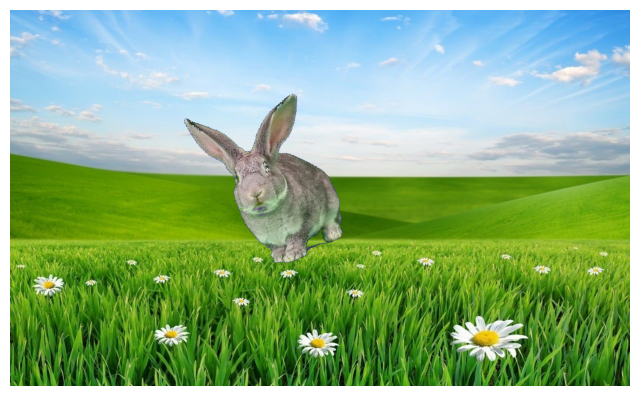

In [50]:
try:
    while True:
        stop = input("Enter 'stop' to exit or press Enter to continue: ")
        if stop.lower() == 'stop':
            break

        bg_path = input("Enter background image path (e.g., background.jpg): ")
        fg_path = input("Enter foreground image path (e.g., foreground.png): ")

        overlay = ImageOverlay(bg_path, fg_path)

        tolerance = int(input("Enter tolerance (e.g., 30): "))
        overlay.create_mask(tolerance)
        x = int(input("Enter x coordinate: "))
        y = int(input("Enter y coordinate: "))
        angle = float(input("Enter rotation angle (degrees): "))

        result = overlay.overlay(x, y, angle)
        overlay.show(result)

except Exception as e:
    print(f"Error: {e}")